In [1]:
import os
import pynwb
import h5py
from tqdm import tqdm
import pandas as pd
from pathlib import Path
import numpy as np
import seaborn as sns
import pywt
import matplotlib
import graph
import time
import pickle

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import gridspec

from scipy import signal
from scipy.fftpack import next_fast_len
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter1d
from scipy.signal import filtfilt, hilbert, remez, sosfiltfilt, butter, find_peaks
import pingouin as pg
from scipy.stats import fisher_exact


import load_data
import LFP
import single_neuron_vis

In [2]:
class ThetaDataset:
    
    def __init__(self, h5_path):
        self.f = h5py.File(h5_path, 'r')
        self.band_sig = self.f['band_sig']
        self.power = self.f['power']
        self.phase = self.f['phase']

    def get_trace(self, time):
        return self.band_sig[time, :].T, self.power[time, :].T, self.phase[time, :].T

    def get_band_sig(self, time):
        if len(time)==0:
            return self.band_sig[:]
        else:
            return self.band_sig[time, :]

    def get_power(self, time):
        if len(time)==0:
            return self.power[:]
        else:
            return self.power[time, :]

    def get_phase(self, time):
        if len(time)==0:
            return self.phase[:]
        else:
            return self.phase[time, :]

    def close(self):
        self.f.close()

In [3]:
sz1 = 12
sz2 = 18
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
matplotlib.rc('xtick', labelsize=sz1) 
matplotlib.rc('ytick', labelsize=sz1) 
matplotlib.rc('axes', labelsize=sz1)  
matplotlib.rc('axes', titlesize=sz1)  
matplotlib.rc('figure', titlesize=sz2)
matplotlib.rc('legend', fontsize=sz1) 
matplotlib.rc('legend', title_fontsize=sz1)
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

In [4]:
def epoch_aligned_lfp(date,df,window):
    
    timestamps, lfpData = load_data.load_LFP(date)
    num_ch = lfpData.shape[1]
    aligned_lfp = np.zeros((len(df),num_ch,window[1]-window[0]))  # 1 if happened during ITI, 0 if during a trial
    
    for ii in range(len(df)):

        on = df.iloc[ii].t_on.astype(float)
        idx = (timestamps>on+window[0]) & (timestamps<on+window[1])
        aligned_lfp[ii,:,:] = lfpData[idx,:].T.astype(np.float32)
    
    return aligned_lfp

In [5]:
def epoch_aligned_band(date,df,window):


    timestamps, lfpData = load_data.load_LFP(date)
    ds = ThetaDataset("D:/Theta/Session_%s_theta.h5" % date)
    
    num_ch = ds.band_sig.shape[1]
    aligned_lfp = np.zeros((len(df),num_ch,window[1]-window[0])).astype(np.float32)
    aligned_signal = np.zeros((len(df),num_ch,window[1]-window[0])).astype(np.float32)
    aligned_power = np.zeros((len(df),num_ch,window[1]-window[0])).astype(np.float32)
    aligned_phase = np.zeros((len(df),num_ch,window[1]-window[0])).astype(np.float32)
    
    for ii in range(len(df)):

        on = df.iloc[ii].t_on.astype(float)
        idx = (timestamps>on+window[0]) & (timestamps<on+window[1])
        aligned_lfp[ii,:,:] = lfpData[idx,:].T.astype(np.float32)
        aligned_signal[ii,:,:], aligned_power[ii,:,:], aligned_phase[ii,:,:] = ds.get_trace(idx)

    ds.close()
    
    return {'LFP': aligned_lfp,
            'band': aligned_signal, 
            'power': aligned_power, 
            'phase': aligned_phase}

In [6]:
def get_phase_channel(phase_align):
    
    # find the channel with highest theta cross-trial phase alignment
    OFC_phase = phase_align[:96,:,:]
    idx = np.argmax(OFC_phase)                 # flat index
    OFC_channel, _, _ = np.unravel_index(idx, OFC_phase.shape)
    
    HPC_phase = phase_align[96:,:,:]
    idx = np.argmax(HPC_phase)                 # flat index
    channel_idx, _, _ = np.unravel_index(idx, HPC_phase.shape)
    HPC_channel = np.arange(96,phase_align.shape[0])[channel_idx]

    return OFC_channel, HPC_channel

In [ ]:
def circular_linear_regression(X,y):

In [7]:
# load data
date = '031723'
nwbfile = load_data.load_nwbfile('Bart',date) 
timestamps, lfpData = load_data.load_LFP('031723')
lfpFile = h5py.File('D:/Teleworld/bart_I/raw/spikes/Bart_TeleWorld_v13_%s-spikes.mat' % date, 'r')
spikeTable = lfpFile['spikeTable'][:len(timestamps),:]
unitNames = nwbfile.units.to_dataframe()
channelNumbers = unitNames.channelNumbers.values

query = 'trialerror<2'
trial_df = nwbfile.intervals['trials'].to_dataframe().query(query)
trial_df['t_on']=trial_df['start_time']

node_df = nwbfile.intervals['node_on'].to_dataframe().query(query)
action_df = nwbfile.intervals['action_on'].to_dataframe().query(query)
# reward_df = nwbfile.intervals['reward_on'].to_dataframe().query(query)
# fix_df = nwbfile.intervals['fixations'].to_dataframe().query(query)

# get aligned_power for all trials
# trial_aligned = epoch_aligned_band(date,trial_df,[-3000,1000])
# node_aligned = epoch_aligned_band(date,node_df,[0,1500])
# action_aligned = epoch_aligned_band(date,action_df,[-1000,1000])
# reward_aligned = epoch_aligned_band(date,reward_df,[-1000,3000])
# fix_aligned = epoch_aligned_band(date,fix_df,[-500,500])

In [84]:
reward_df = nwbfile.intervals['reward_on'].to_dataframe().query(query)
fix_df = nwbfile.intervals['fixations'].to_dataframe().query(query)


In [34]:
hpc_tuning = pd.read_pickle("D:/SingleNeuron/Tuning first step HPC.pkl")
ofc_tuning = pd.read_pickle("D:/SingleNeuron/Tuning first step OFC.pkl")
session_tuning = pd.concat([ofc_tuning.query('Session==@date'),hpc_tuning.query('Session==@date')])
spatial_pval=np.min(np.vstack(session_tuning['spatial_ftest_pval']),axis=1)
neuronID_sorted = session_tuning.unitNumber.values[np.argsort(spatial_pval)]

In [112]:
neuronID_sorted

array([ 40., 103., 131., 162., 193., 195., 159., 191., 192.,  60., 188.,
       130.,  33., 199., 134., 202.,  27., 111., 196.,  98., 148.,   7.,
       197., 114.,  34.,  35.,  25.,  97., 150.,   3., 164., 116.,  26.,
       186.,  28., 204.,  55., 190.,  46., 115., 201., 198., 183.,  45.,
       158., 170.,  42., 107.,  50.,  53., 125.,   5., 126., 176.,  86.,
         9.,  15.,   4., 167.,  12.,  62.,  14.,  17.,  68.,  85.,  79.,
         8., 149.,  43., 128.,  41., 171., 185., 108.,  30.,  54., 166.,
        16., 100.,   6., 152.,  75.,  70.,  83., 118.,  71.,  61., 205.,
       112.,  10., 180.,  18.,   1., 169.,  64.,  66.,  22.,  31.,  67.,
       182.,  73.,  21., 168.,  81.,  20., 177., 181.,  59., 110., 175.,
        88.,  38.,  87., 132., 122.,  47., 179.,  84.,  24., 140., 189.,
        23.,  91., 135., 119.,  89., 104.,  78.,  19.,  37.,  51.,  36.,
       124., 147.,  44.,  80., 139., 129., 121.,  29.,  76.,  77., 143.,
        63., 141., 172.,  95.,  74.,  58.,  13.,  7

<Axes: title={'center': 'SDF'}, xlabel='Action on', ylabel='Firing rate'>

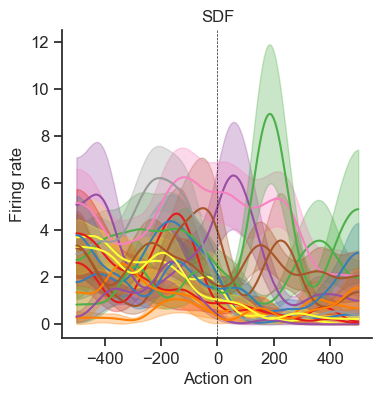

In [120]:
# data = load_data.load_beh_neural('Bart', '031723', 'HPC', 'action_on', '(trialerror<2) & (step==0)')
single_neuron_vis.plot_sdf(data, 202,'node', sns.color_palette('Set1',16), ax=None)

Building Spike Table


228it [00:00, 3478.14it/s]


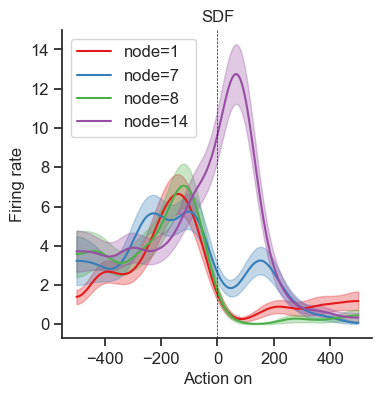

In [133]:
data = load_data.load_beh_neural('Bart', '031723', 'HPC', 'action_on', 
                                 '(trialerror==1) & (step==0)')
ax = single_neuron_vis.plot_sdf(data, 195,'node', sns.color_palette('Set1',16), ax=None)
ax.legend()

Building Spike Table


228it [00:00, 3587.51it/s]


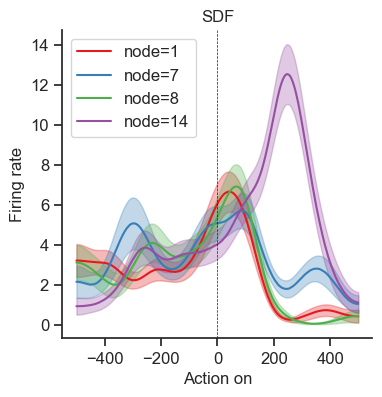

In [138]:
data = load_data.load_beh_neural('Bart', '031723', 'HPC', 'node_on', 
                                 '(trialerror==1) & (step==0)')
ax = single_neuron_vis.plot_sdf(data, 195,'node', sns.color_palette('Set1',16), ax=None)
ax.legend()

Building Spike Table


113it [00:00, 3176.78it/s]


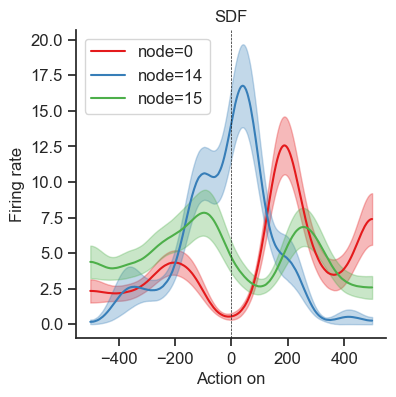

In [140]:
data = load_data.load_beh_neural('Bart', '031723', 'HPC', 'action_on', 
                                 '(trialerror==0) & (step==0) & ((node==15) | (node==0) | (node==14))')
ax = single_neuron_vis.plot_sdf(data, 195,'node', sns.color_palette('Set1',16), ax=None)
ax.legend()

Building Spike Table


50it [00:00, 3396.47it/s]


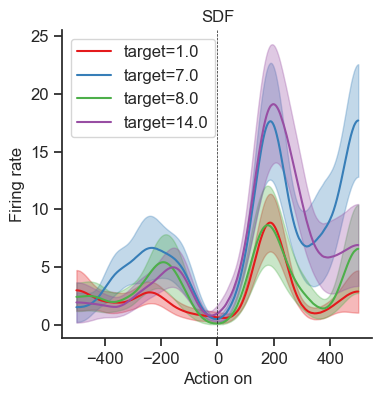

In [164]:
data = load_data.load_beh_neural('Bart', '031723', 'HPC', 'action_on', 
                                 '(trialerror==0) & (step==0) & (node==0)')
ax = single_neuron_vis.plot_sdf(data, 195,'target', sns.color_palette('Set1',16), ax=None)
ax.legend()

Building Spike Table


15it [00:00, 2990.38it/s]


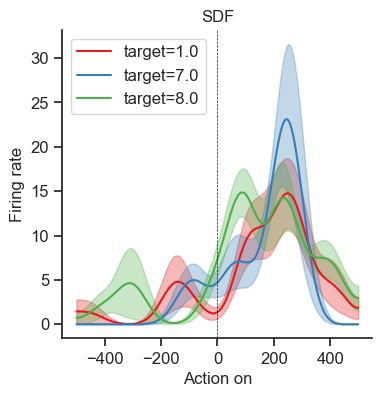

In [256]:
data = load_data.load_beh_neural('Bart', '031723', 'HPC', 'node_on', 
                                 '(trialerror==0) & (step==0) & (node==14)')
ax = single_neuron_vis.plot_sdf(data, 195,'target', sns.color_palette('Set1',16), ax=None)
ax.legend()

Building Spike Table


113it [00:00, 2914.07it/s]


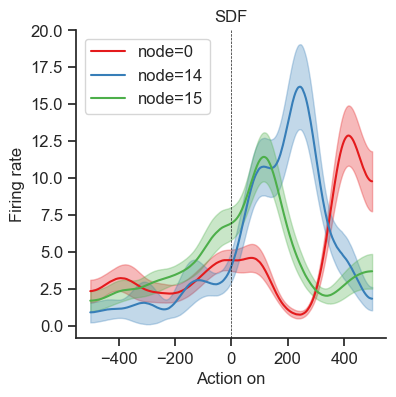

In [135]:
data = load_data.load_beh_neural('Bart', '031723', 'HPC', 'node_on', 
   '(trialerror==0) & (step==0) & ((node==15) | (node==0) | (node==14))')
ax = single_neuron_vis.plot_sdf(data, 195,'node', sns.color_palette('Set1',16), ax=None)
ax.legend()

Building Spike Table


222it [00:00, 3456.51it/s]


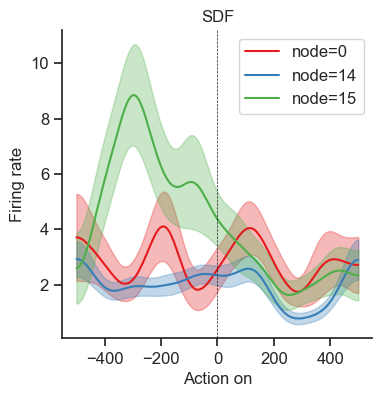

In [136]:
data = load_data.load_beh_neural('Bart', '031723', 'HPC', 'action_on', 
   '(trialerror==0) & (step>0) & ((node==15) | (node==0) | (node==14))')
ax = single_neuron_vis.plot_sdf(data, 195,'node', sns.color_palette('Set1',16), ax=None)
ax.legend()

Building Spike Table


222it [00:00, 1886.96it/s]


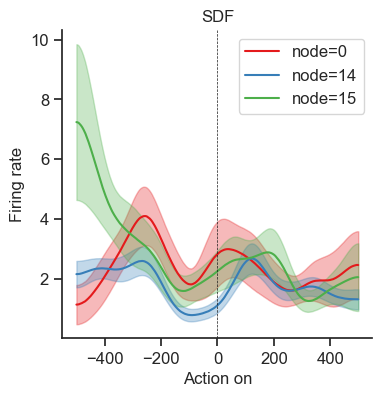

In [137]:
data = load_data.load_beh_neural('Bart', '031723', 'HPC', 'node_on', 
   '(trialerror==0) & (step>0) & ((node==15) | (node==0) | (node==14))')
ax = single_neuron_vis.plot_sdf(data, 195,'node', sns.color_palette('Set1',16), ax=None)
ax.legend()

Building Spike Table


1727it [00:00, 3234.83it/s]


<Axes: title={'center': 'SDF'}, xlabel='Action on', ylabel='Firing rate'>

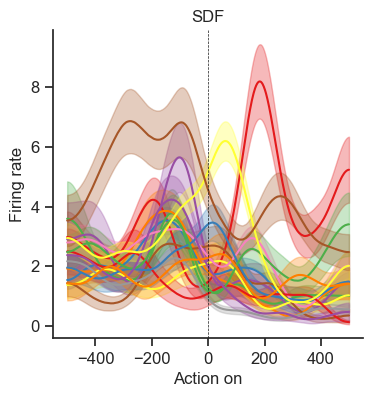

In [42]:
spikeTable = load_data.load_beh_neural('Bart', '031723', 'HPC', 'action_on', '(trialerror<2)')
single_neuron_vis.plot_sdf(spikeTable, 195,'node', sns.color_palette('Set1',16), ax=None)

Building Spike Table


1727it [00:00, 3947.26it/s]


<Axes: title={'center': 'SDF'}, xlabel='Action on', ylabel='Firing rate'>

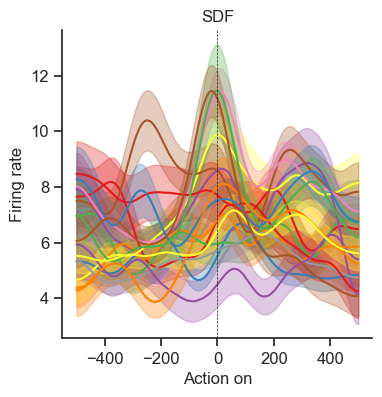

In [63]:
spikeTable = load_data.load_beh_neural('Bart', '031723', 'HPC', 'action_on', '(trialerror<2)')
single_neuron_vis.plot_sdf(spikeTable, 196,'node', sns.color_palette('Set1',16), ax=None)

<Axes: title={'center': 'SDF'}, xlabel='Action on', ylabel='Firing rate'>

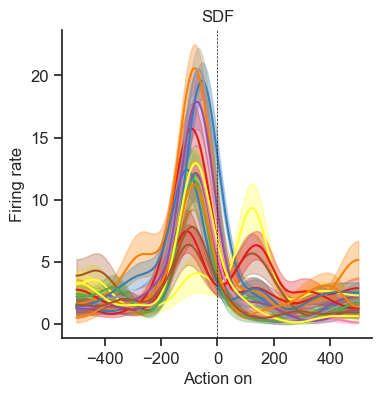

In [11]:
spikeTable = load_data.load_beh_neural('Bart', '031723', 'HPC', 'action_on', '(trialerror<2) & (step==0)')
single_neuron_vis.plot_sdf(spikeTable, 188,'node', sns.color_palette('Set1',16), ax=None)

In [227]:
# reaction time for the first choice in a trial
RT = action_df.query('(trialerror==0) & (step==0)').t_on.values - node_df.query('(trialerror==0) & (step==0)').t_on.values

In [112]:
query = 'trialerror < 2'
dates = ['031723','032023','032823','033123','040423','040723']

for date in dates:

    # ---------------- Load once ----------------
    nwbfile = load_data.load_nwbfile('Bart', date)
    node_df = nwbfile.intervals['node_on'].to_dataframe().query(query)

    timestamps, lfpData = load_data.load_LFP(date)

    lfpFile = h5py.File(
        f'D:/Teleworld/bart_I/raw/spikes/Bart_TeleWorld_v13_{date}-spikes.mat', 'r'
    )
    spikeTable = lfpFile['spikeTable'][:len(timestamps), :]

    unit_df = nwbfile.units.to_dataframe()
    channelNumbers = unit_df.channelNumbers.values - 1
    n_units = len(unit_df)

    ds = ThetaDataset(f"D:/Theta/Session_{date}_theta.h5")

    # ---------------- Precompute trial windows ----------------
    trials = node_df.trial.unique()
    trial_info = []

    for trial in trials:
        idx = (node_df.trial == trial) & (node_df.step == 0)
        t_on = node_df.t_on.values[idx][0]
        time_idx = (timestamps > t_on) & (timestamps < (t_on + 1500))
        trial_info.append(time_idx)

    # ---------------- Compute PLV ----------------
    all_PLV = [[] for _ in range(n_units)]

    for time_idx in tqdm(trial_info, desc=f"{date} trials"):
        phase = ds.get_phase(time_idx)  # shape: [time, channel]

        for unit in range(n_units):
            channel = channelNumbers[unit]
            spikes = spikeTable[time_idx, unit].astype(bool)
            all_PLV[unit].append(phase[spikes, channel])

    ds.close()
    lfpFile.close()

    # ---------------- Rayleigh tests ----------------
    flash_pval = np.zeros(n_units)
    nav_pval   = np.zeros(n_units)

    trialerror = node_df.drop_duplicates('trial').trialerror.values

    for unit in range(n_units):
        plv_trials = all_PLV[unit]

        for cond, label in [(1, 'flash'), (0, 'nav')]:
            idx = trialerror == cond
            plv = np.concatenate([x for x, keep in zip(plv_trials, idx) if keep])

            if len(plv) < 5:
                pval = np.nan
            else:
                _, pval = pg.circ_rayleigh(plv)

            if label == 'flash':
                flash_pval[unit] = pval
            else:
                nav_pval[unit] = pval

    # ---------------- Save ----------------
    out = dict(
        PLV=all_PLV,
        flash_pval=flash_pval,
        nav_pval=nav_pval
    )

    with open(f'D:/Theta/Session_{date}_node_on_0_1500_PLV.pkl', 'wb') as f:
        pickle.dump(out, f)


040723 trials: 100%|██████████| 835/835 [16:24<00:00,  1.18s/it]


In [66]:
timestamps, lfpData = load_data.load_LFP(date)

lfpFile = h5py.File(
    f'D:/Teleworld/bart_I/raw/spikes/Bart_TeleWorld_v13_{date}-spikes.mat', 'r'
)
spikeTable = lfpFile['spikeTable'][:len(timestamps), :]

unit_df = nwbfile.units.to_dataframe()
channelNumbers = unit_df.channelNumbers.values - 1
n_units = len(unit_df)

ds = ThetaDataset(f"D:/Theta/Session_{date}_theta.h5")

In [101]:
fix_df = fix_df.query('duration>50')

In [88]:
def plot_beh_event(trial, ax, color='w'): 

    this_trial = trial_df[trial_df.trial==trial]
    trial_on = this_trial.start_time.values[0]
    trial_end = this_trial.stop_time.values[0]-trial_on
    node_on = node_df.query('(trial==@trial)').t_on.values-trial_on
    action_on = action_df.query('trial==@trial').t_on.values-trial_on
    reward_on = reward_df.query('trial==@trial').t_on.values-trial_on

    # if len(color)==0:
    #     ax.axvline(node_on,color='r')
    #     ax.axvline(action_on,color='g')
    #     ax.axvline(reward_on,color='b')
    # else:
    #     ax.axvline(node_on,color=color)
    #     ax.axvline(action_on,color=color)
    #     ax.axvline(reward_on,color=color)

    if len(color) == 0:
        colors = {'node': 'r', 'action': 'g', 'reward': 'b'}
    else:
        colors = {'node': color, 'action': color, 'reward': color}

    # Ensure everything is iterable
    def to_iter(x):
        return x if np.iterable(x) and not isinstance(x, (str, bytes)) else [x]

    node_on   = to_iter(node_on)
    action_on = to_iter(action_on)
    reward_on = to_iter(reward_on)

    # Plot each event
    for x in node_on:
        ax.axvline(x, color=colors['node'])
    for x in action_on:
        ax.axvline(x, color=colors['action'])
    for x in reward_on:
        ax.axvline(x, color=colors['reward'])
        
    ax.set_xlim(0,trial_end)


def plot_eye_trace(trial, ax, eye_idx=2):
    
    trial_of_interest = trial_df[trial_df.trial==trial] 
    fixations_during_trial = fix_df[fix_df.trial==trial] 
    
    eyes = trial_of_interest.timeseries.iloc[0][eye_idx]   
    fixation_trace = eyes.data
    
    ax.plot(fixation_trace[:, 0],color='gray')
    ax.plot(fixation_trace[:, 1],color='lightgray')



def plot_fixation_nodes(trial, ax, eye_idx=2):
    
    this_trial = trial_df[trial_df.trial==trial] 
    fixations_during_trial = fix_df[fix_df.trial==trial] 

    trial_on = this_trial.start_time.values[0]
    
    eyes = this_trial.timeseries.iloc[0][eye_idx]   

    # this is to plot x,y 2d plane
    for _, fix in fixations_during_trial.iterrows():

        fix_node = fix.fix_node
        if fix.active_prob>0.8:
            ax.axvspan(fix.start_time-trial_on,fix.stop_time-trial_on,0,1,color='red',alpha=0.15)
        if fix.active_prob<0.2:
            ax.axvspan(fix.start_time-trial_on,fix.stop_time-trial_on,0,1,color='blue',alpha=0.15)
        ax.text(fix.start_time-trial_on,0.8,str(fix_node),fontsize=16)

    trial_end = this_trial.stop_time.values[0]-trial_on
    ax.set_xlim(0,trial_end)
    

In [ ]:
# if phase locking exists beyond first step

In [ ]:
# how to look at phase precession
# at node 0
# node ? to node 0
# node 0 to node?

# especially node 15

In [285]:
def complex_average_phase(phase):
    """
    phase: array (n_channels, n_timepoints)
    returns: avg_phase (n_timepoints)
    """
    # Convert phases to unit complex vectors using Euler's formula
    complex_vec = np.exp(1j * phase)     # N × T complex numbers

    # Average across channels
    z_avg = complex_vec.mean(axis=0)     # length T complex array

    # Extract the phase of the average
    avg_phase = np.angle(z_avg)

    return avg_phase

In [328]:
# look at individual trial
#ds = ThetaDataset(f"D:/Theta/Session_{date}_theta.h5")
trials = node_df.trial.unique()
all_phase = np.zeros((2,len(trials),500))

for ii,trial in enumerate(trials):
    
    this_trial = node_df.query('(trial==@trial)&(step==0)')
    t_on = this_trial.t_on.values[0]
    time_idx = (timestamps > t_on) & (timestamps < (t_on+500))
    
    phase = ds.get_phase(time_idx)  # shape: [time, channel]
    all_phase[0,ii,:] = complex_average_phase(phase[:,:96].T)
    all_phase[1,ii,:] = complex_average_phase(phase[:,96:].T)

In [340]:
# unwrap 1500ms / first 10 cycles of theta oscillation
unit = 12
trials = node_df.query('(trialerror==0)').trial.unique()
plv=[[],[]]

for ii,trial in enumerate(trials):
    
    this_trial = node_df.query('(trial==@trial)&(step==0)')
    t_on = this_trial.t_on.values[0]
    time_idx = (timestamps > t_on) & (timestamps < (t_on+1500))
    
    phase = ds.get_phase(time_idx)  # shape: [time, channel]
    ofc_phase = complex_average_phase(phase[:,:96].T)
    hpc_phase = complex_average_phase(phase[:,96:].T)
        
    spikes = spikeTable[time_idx, unit].astype(bool)
    plv[0].append(ofc_phase[spikes])
    plv[1].append(hpc_phase[spikes])

plt.close('all')
plt.hist(np.concatenate(plv[0]),bins=np.arange(-np.pi,np.pi,0.2),alpha=0.4)
plt.hist(np.concatenate(plv[1]),bins=np.arange(-np.pi,np.pi,0.2),alpha=0.4)

In [329]:
flash = all_phase[:,node_df.query('step==0').trialerror==1,:]
nav = all_phase[:,node_df.query('step==0').trialerror==0,:]

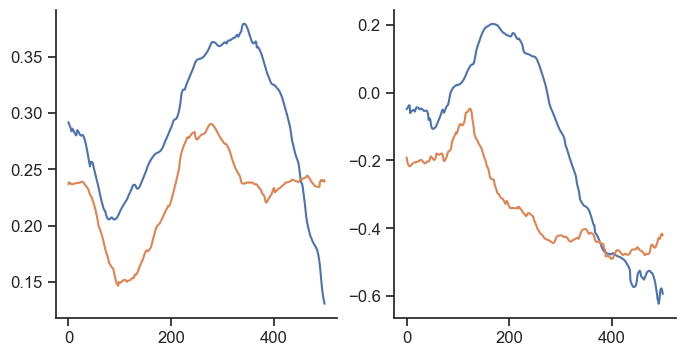

In [330]:
plt.close('all')
fig, axes = plt.subplots(1,2,figsize=(8,4))

dphi = flash[1,:,:] - flash[0,:,:]

length = np.zeros(dphi.shape[1])
angle = np.zeros(dphi.shape[1])
for t in range(dphi.shape[1]):
    temp = np.mean(np.exp(1j * dphi[:,t]))
    length[t] = np.abs(temp)
    angle[t] = np.angle(temp)

axes[0].plot(length,label='flash')
axes[1].plot(angle,label='flash')


dphi = nav[1,:,:] - nav[0,:,:]

length = np.zeros(dphi.shape[1])
angle = np.zeros(dphi.shape[1])
for t in range(dphi.shape[1]):
    temp = np.mean(np.exp(1j * dphi[:,t]))
    length[t] = np.abs(temp)
    angle[t] = np.angle(temp)

axes[0].plot(length,label='nav')
axes[1].plot(angle,label='nav')

# axes[0].axvline(1500,color='k')
# axes[0].axvline(2000,color='k')

# axes[1].axvline(1500,color='k')
# axes[1].axvline(2000,color='k')

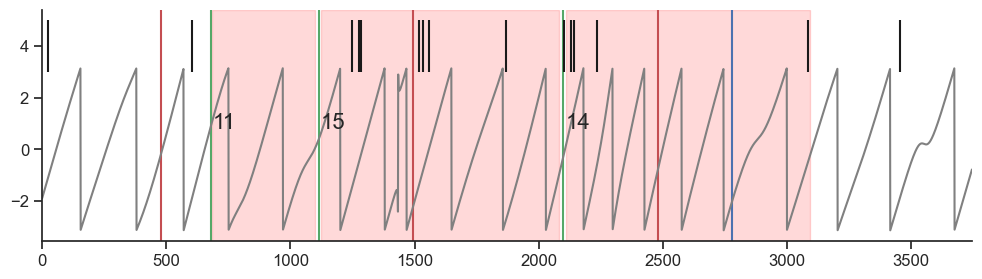

In [143]:
# look at individual trial
unit = 194
trials = node_df.query('node==14').trial.unique()
trial = trials[20]

# for trial in trials:
    
this_trial = trial_df.query('trial==@trial')
time_idx = (timestamps > this_trial.start_time.values[0]) & (timestamps < this_trial.stop_time.values[0])

phase = ds.get_phase(time_idx)  # shape: [time, channel]

channel = channelNumbers[unit]
spikes = spikeTable[time_idx, unit].astype(bool)

plt.close('all')
fig, axes = plt.subplots(figsize=(12,3))

plot_beh_event(trial, axes,color=[])
plot_fixation_nodes(trial, axes)

axes.plot(phase[:,channel],color='gray')
x,y = np.where(spikes.reshape(-1,1))
axes.vlines(x,3,5,color='k')

In [ ]:
    phase_unwrapped = np.unwrap(phase)

    # 5. Each 2π increase = 1 cycle
    total_cycles = (phase_unwrapped[-1] - phase_unwrapped[0]) / (2*np.pi)

(array([ 5.,  8., 12., 18., 16., 11., 10.,  7.,  9.,  8.,  3.,  4.,  0.,
         1.,  4.,  4.,  4.,  4.,  8.]),
 array([-3.14159265, -2.81089869, -2.48020473, -2.14951076, -1.8188168 ,
        -1.48812284, -1.15742887, -0.82673491, -0.49604095, -0.16534698,
         0.16534698,  0.49604095,  0.82673491,  1.15742887,  1.48812284,
         1.8188168 ,  2.14951076,  2.48020473,  2.81089869,  3.14159265]),
 <BarContainer object of 19 artists>)

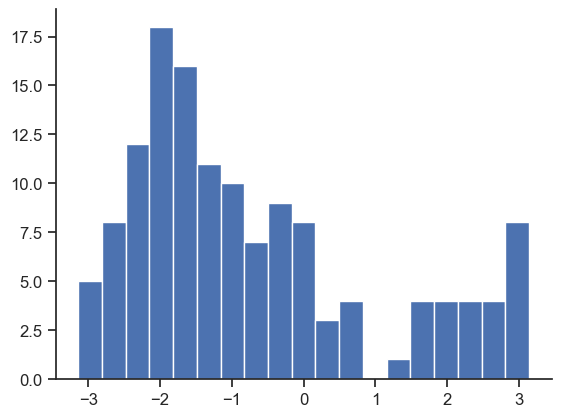

In [254]:
# unwrap 1500ms / first 10 cycles of theta oscillation
unit = 194
channel = channelNumbers[unit]
trials = node_df.query('(trialerror==0)&(step==0)&(node==0)').trial.unique()

plv = [[],[]]

for ii, trial in enumerate(trials):

    for s in range(2):
        
        step = node_df.query('(trial==@trial)&(step==@s)')
        
        t_on = step.t_on.values[0]
        time_idx = (timestamps > t_on) & (timestamps < (t_on+500))
        
        phase = ds.get_phase(time_idx)[:,channel]  # shape: [time, channel]
        # unwrapped = np.unwrap(phase,period=2*np.pi)
        
        channel = channelNumbers[unit]
        spikes = spikeTable[time_idx, unit].astype(bool)
        plv[s].append(phase[spikes])

plt.close('all')
plt.hist(np.concatenate(plv[0]),np.linspace(-np.pi,np.pi,20))
# plt.hist(np.concatenate(plv[1]),np.linspace(-np.pi,np.pi,20))

(array([0., 1., 0., 2., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0.]),
 array([-3.14159265, -2.81089869, -2.48020473, -2.14951076, -1.8188168 ,
        -1.48812284, -1.15742887, -0.82673491, -0.49604095, -0.16534698,
         0.16534698,  0.49604095,  0.82673491,  1.15742887,  1.48812284,
         1.8188168 ,  2.14951076,  2.48020473,  2.81089869,  3.14159265]),
 <BarContainer object of 19 artists>)

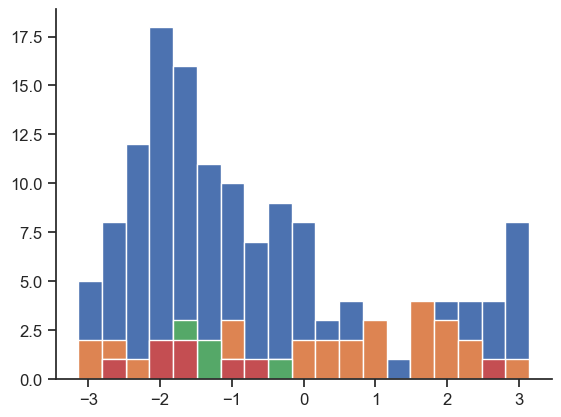

In [237]:
# unwrap 1500ms / first 10 cycles of theta oscillation
unit = 194
channel = channelNumbers[unit]
trials = node_df.query('(trialerror==0)&(node==0)').trial.unique()

plv = [[],[],[],[]]

for ii, trial in enumerate(trials):

    for s in range(4):
        
        step = node_df.query('(trial==@trial)&(step==@s)&(node==0)')

        if len(step)>0:
        
            t_on = step.t_on.values[0]
            time_idx = (timestamps > t_on) & (timestamps < (t_on+500))
            
            phase = ds.get_phase(time_idx)[:,channel]  # shape: [time, channel]
            # unwrapped = np.unwrap(phase,period=2*np.pi)
            
            channel = channelNumbers[unit]
            spikes = spikeTable[time_idx, unit].astype(bool)
            plv[s].append(phase[spikes])

plt.close('all')
plt.hist(np.concatenate(plv[0]),np.linspace(-np.pi,np.pi,20))
plt.hist(np.concatenate(plv[1]),np.linspace(-np.pi,np.pi,20))
plt.hist(np.concatenate(plv[2]),np.linspace(-np.pi,np.pi,20))
plt.hist(np.concatenate(plv[3]),np.linspace(-np.pi,np.pi,20))

(array([13., 16., 13., 10.,  5., 11., 13.,  8.,  6.,  4.,  5.,  2.,  8.,
        11., 10., 13., 11., 11., 12.]),
 array([-3.14159265, -2.81089869, -2.48020473, -2.14951076, -1.8188168 ,
        -1.48812284, -1.15742887, -0.82673491, -0.49604095, -0.16534698,
         0.16534698,  0.49604095,  0.82673491,  1.15742887,  1.48812284,
         1.8188168 ,  2.14951076,  2.48020473,  2.81089869,  3.14159265]),
 <BarContainer object of 19 artists>)

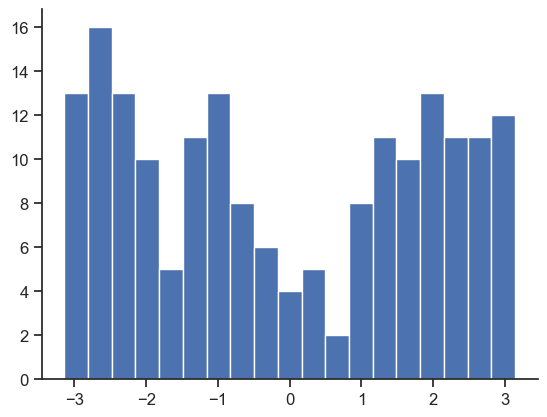

In [241]:
# unwrap 1500ms / first 10 cycles of theta oscillation
unit = 194
channel = channelNumbers[unit]
trials = node_df.query('(trialerror==1)&(node==14)').trial.unique()

plv = [[],[],[],[]]

for ii, trial in enumerate(trials):

    for s in range(1):
        
        step = node_df.query('(trial==@trial)&(step==@s)&(node==14)')

        if len(step)>0:
        
            t_on = step.t_on.values[0]
            time_idx = (timestamps > t_on) & (timestamps < (t_on+500))
            
            phase = ds.get_phase(time_idx)[:,channel]  # shape: [time, channel]
            # unwrapped = np.unwrap(phase,period=2*np.pi)
            
            channel = channelNumbers[unit]
            spikes = spikeTable[time_idx, unit].astype(bool)
            plv[s].append(phase[spikes])

plt.close('all')
plt.hist(np.concatenate(plv[0]),np.linspace(-np.pi,np.pi,20))
# plt.hist(np.concatenate(plv[1]),np.linspace(-np.pi,np.pi,20))
# plt.hist(np.concatenate(plv[2]),np.linspace(-np.pi,np.pi,20))
# plt.hist(np.concatenate(plv[3]),np.linspace(-np.pi,np.pi,20))

(array([1., 0., 0., 2., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1.,
        0., 1.]),
 array([-3.14159265, -2.81089869, -2.48020473, -2.14951076, -1.8188168 ,
        -1.48812284, -1.15742887, -0.82673491, -0.49604095, -0.16534698,
         0.16534698,  0.49604095,  0.82673491,  1.15742887,  1.48812284,
         1.8188168 ,  2.14951076,  2.48020473,  2.81089869,  3.14159265]),
 <BarContainer object of 19 artists>)

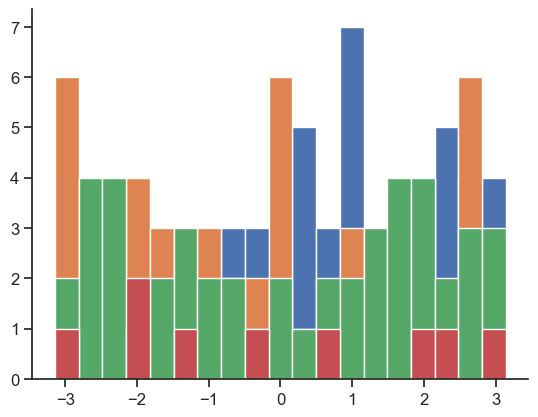

In [248]:
# unwrap 1500ms / first 10 cycles of theta oscillation
unit = 194
channel = channelNumbers[unit]
trials = node_df.query('(trialerror==0)&(node==14)').trial.unique()

plv = [[],[],[],[]]

for ii, trial in enumerate(trials):

    for s in range(4):
        
        step = node_df.query('(trial==@trial)&(step==@s)&(node==14)')

        if len(step)>0:
        
            t_on = step.t_on.values[0]
            time_idx = (timestamps > t_on) & (timestamps < (t_on+500))
            
            phase = ds.get_phase(time_idx)[:,channel]  # shape: [time, channel]
            # unwrapped = np.unwrap(phase,period=2*np.pi)
            
            channel = channelNumbers[unit]
            spikes = spikeTable[time_idx, unit].astype(bool)
            plv[s].append(phase[spikes])

plt.close('all')
plt.hist(np.concatenate(plv[0]),np.linspace(-np.pi,np.pi,20))
plt.hist(np.concatenate(plv[1]),np.linspace(-np.pi,np.pi,20))
plt.hist(np.concatenate(plv[2]),np.linspace(-np.pi,np.pi,20))
plt.hist(np.concatenate(plv[3]),np.linspace(-np.pi,np.pi,20))

In [198]:
def preferred_phase(phases):
    # phases in radians
    z = np.exp(1j * phases)     # convert to complex numbers on unit circle
    mean_vector = np.mean(z)    # mean complex number
    mu = np.angle(mean_vector)  # angle of mean vector in [-pi, pi]
    return mu

In [ ]:
plt.close('all')
fig, axes = plt.subplots(4,4,figsize=(12,12),sharey=True)
for ii in range(16):
    row,col=np.divmod(ii,4)
    idx = np.where(action_df.query('step==0').node.values==ii)[0]
    a_selected = np.concatenate([a[i] for i in idx])
    sns.histplot(data=a_selected,bins=np.linspace(-np.pi,np.pi,20),ax=axes[row,col])
    axes[row,col].set_title('node %i' % ii)

In [216]:
date='031723'
# with open(f'D:/Theta/Session_{date}_node_on_0_500_PLV.pkl', 'rb') as f:
#     data1 = pickle.load(f)

with open(f'D:/Theta/Session_{date}_node_on_0_1500_PLV.pkl', 'rb') as f:
    data2 = pickle.load(f)

In [190]:
nwbfile = load_data.load_nwbfile('Bart', date)
unitNames = nwbfile.units.to_dataframe()

In [217]:
a = data2['PLV'][194]

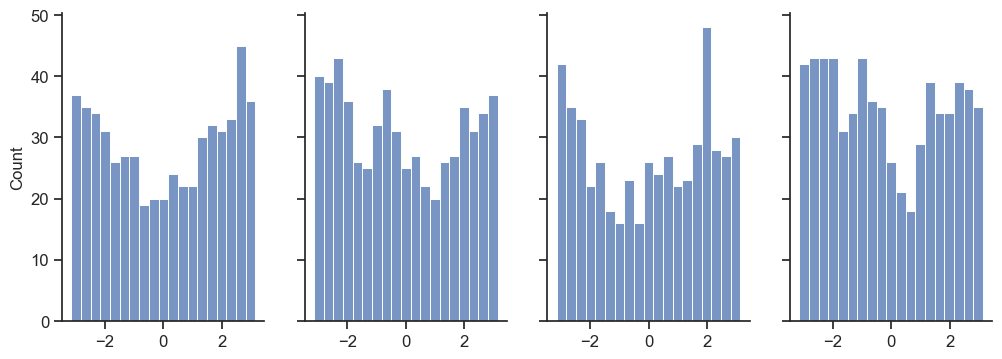

In [146]:
plt.close('all')
fig, axes = plt.subplots(1,4,figsize=(12,4),sharey=True)
for ii,goal in enumerate([1,7,8,14]):
    idx = np.where(trial_df.target.values==goal)[0]
    a_selected = np.concatenate([a[i] for i in idx])
    sns.histplot(data=a_selected,bins=np.linspace(-np.pi,np.pi,20),ax=axes[ii])

In [201]:
for date in dates:
    lfpFile = h5py.File(
    f'D:/Teleworld/bart_I/raw/spikes/Bart_TeleWorld_v13_{date}-spikes.mat', 'r'
    )
    print('LFP length', lfpFile['lfpTable'].shape[0])
    print('spike length',lfpFile['spikeTable'].shape[0]-lfpFile['lfpTable'].shape[0])

LFP length 5402062
spike length 11
LFP length 5788213
spike length 14
LFP length 4934687
spike length 21
LFP length 5348865
spike length 34
LFP length 6531956
spike length 8
LFP length 5306069
spike length 11


In [202]:
date='031723'
unit = 187 # 188, but -1 for indexing
# nwbfile = load_data.load_nwbfile('Bart', date)
node_df = nwbfile.intervals['node_on'].to_dataframe().query(query)

timestamps, lfpData = load_data.load_LFP(date)

lfpFile = h5py.File(
    f'D:/Teleworld/bart_I/raw/spikes/Bart_TeleWorld_v13_{date}-spikes.mat', 'r'
)
spikeTable = lfpFile['spikeTable'][:len(timestamps), :]

unit_df = nwbfile.units.to_dataframe()
channelNumbers = unit_df.channelNumbers.values - 1
n_units = len(unit_df)

ds = ThetaDataset(f"D:/Theta/Session_{date}_theta.h5")

In [230]:
unit_df.query('unitNumber==188')

unitNumber       unitNames  channelNumbers  unitOnChannel  probe  \
id                                                                      
188         188  S01_SPK183_001             183              1      6   

     firingRate   date region    ap    ml  ...  start_channel  end_channel  \
id                                         ...                               
188    2.333178  31723    HPC  12.6  13.5  ...            161          192   

     cell_community  potential_duplicate  keep_cell  subfield  drift  group  \
id                                                                            
188            15.0                  1.0        1.0       CA3    0.0   good   

           fr                                      waveform_mean  
id                                                                
188  2.333178  [-0.0018698600546153956, -0.002049954896691519...  

[1 rows x 24 columns]

In [ ]:
# phase precession
# look at trials when starting from its fav node
# look at planning trials

# is phase dependent on goal?
# is it just node_on 1500 or the entire trial? what about ITI?

# what about goal cell? are they phase locked or phase precessed?

In [12]:
hpc_tuning = pd.read_pickle("D:/SingleNeuron/Tuning first step HPC.pkl")
ofc_tuning = pd.read_pickle("D:/SingleNeuron/Tuning first step OFC.pkl")
session_tuning = pd.concat([ofc_tuning.query('Session==@date'),hpc_tuning.query('Session==@date')])
spatial_pval=np.min(np.vstack(session_tuning['spatial_ftest_pval']),axis=1)
neuronID_sorted = np.argsort(spatial_pval)

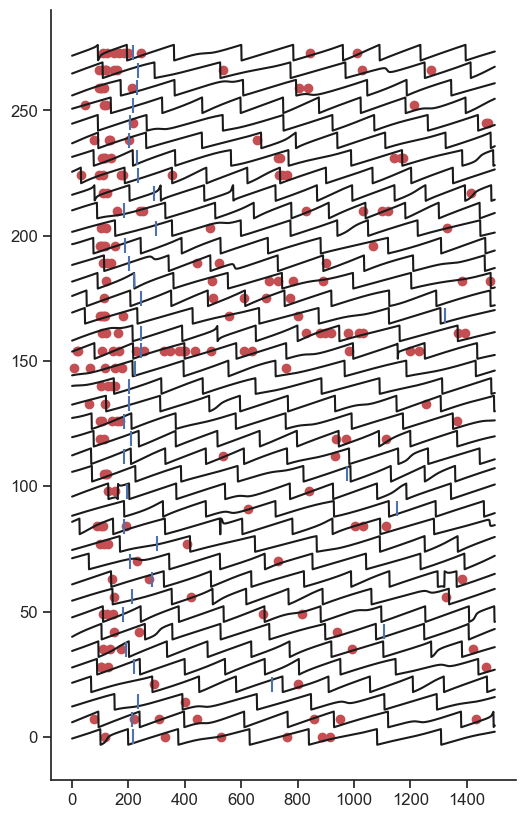

In [240]:
# ---------------- Precompute trial windows ----------------
trials = node_df.query('node==0').trial.unique()
trial_info = []

plt.close('all')
plt.figure(figsize=(6,10))

for ii, trial in enumerate(trials[:40]):
        
    idx = (node_df.trial == trial) & (node_df.step == 0)
    t_on = node_df.t_on.values[idx][0]
    time_idx = (timestamps > t_on) & (timestamps < (t_on + 1500))
    trial_info.append(time_idx)
    
    action_on = action_df.t_on.values[idx][0]
    
    phase = ds.get_phase(time_idx)  # shape: [time, channel]
    
    # for unit in range(n_units):
    channel = channelNumbers[unit]
    spikes = spikeTable[time_idx, unit].astype(bool)
    
    x,y = np.where(spikes.reshape(-1,1))
    
    plt.plot(phase[:,channel]+ii*7,color='k')
    plt.vlines(action_on-t_on,-3+ii*7,3+ii*7,color='b')
    plt.scatter(x,y+ii*7,color='r')

(array([148., 161., 167., 136., 140., 136., 130., 138., 125., 120., 105.,
        101.,  99., 106.,  85.,  87.,  82.,  84.,  72.,  69.,  78.,  89.,
         95., 107.,  90.,  95., 110., 106., 125., 127., 131.]),
 array([-3.14159265, -2.94159265, -2.74159265, -2.54159265, -2.34159265,
        -2.14159265, -1.94159265, -1.74159265, -1.54159265, -1.34159265,
        -1.14159265, -0.94159265, -0.74159265, -0.54159265, -0.34159265,
        -0.14159265,  0.05840735,  0.25840735,  0.45840735,  0.65840735,
         0.85840735,  1.05840735,  1.25840735,  1.45840735,  1.65840735,
         1.85840735,  2.05840735,  2.25840735,  2.45840735,  2.65840735,
         2.85840735,  3.05840735]),
 <BarContainer object of 31 artists>)

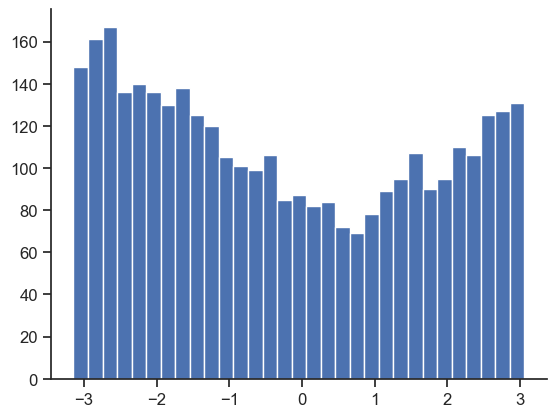

In [198]:
plt.close('all')
plt.hist(np.concatenate(a),bins=np.arange(-np.pi,np.pi,0.2))

In [159]:
hpc_tuning = pd.read_pickle("D:/SingleNeuron/Tuning first step HPC.pkl")
ofc_tuning = pd.read_pickle("D:/SingleNeuron/Tuning first step OFC.pkl")

first_step = pd.DataFrame()

dates = ['031723','032023','032823','033123','040423','040723']

for date in dates:

    # ---------------- Load once ----------------
    nwbfile = load_data.load_nwbfile('Bart', date)
    unitNames = nwbfile.units.to_dataframe()
    
    with open(f'D:/Theta/Session_{date}_node_on_0_500_PLV.pkl', 'rb') as f:
        data = pickle.load(f)
        
    flash_plv_pval = data['flash_pval']
    nav_plv_pal = data['nav_pval']
    
    session_tuning = pd.concat([ofc_tuning.query('Session==@date'),hpc_tuning.query('Session==@date')])
    unit_params = {"drift": 2, "min_fr": 1}  
    unit_idx = np.where((unitNames.group == "good") & (unitNames.drift <= unit_params["drift"]) & (unitNames.fr >= unit_params["min_fr"]))[0]
    good_units = unitNames.iloc[unit_idx]
    session_tuning['flash_PLV'] = flash_plv_pval[unit_idx]<0.01
    session_tuning['nav_PLV'] = nav_plv_pal[unit_idx]<0.01

    first_step = pd.concat([first_step,session_tuning])

In [160]:
hpc_tuning = pd.read_pickle("D:/SingleNeuron/Tuning all steps HPC.pkl")
ofc_tuning = pd.read_pickle("D:/SingleNeuron/Tuning all steps OFC.pkl")

all_steps = pd.DataFrame()

dates = ['031723','032023','032823','033123','040423','040723']

for date in dates:

    # ---------------- Load once ----------------
    nwbfile = load_data.load_nwbfile('Bart', date)
    unitNames = nwbfile.units.to_dataframe()
    
    with open(f'D:/Theta/Session_{date}_node_on_0_500_PLV.pkl', 'rb') as f:
        data = pickle.load(f)
        
    flash_plv_pval = data['flash_pval']
    nav_plv_pal = data['nav_pval']
    
    session_tuning = pd.concat([ofc_tuning.query('Session==@date'),hpc_tuning.query('Session==@date')])
    unit_params = {"drift": 2, "min_fr": 1}  
    unit_idx = np.where((unitNames.group == "good") & (unitNames.drift <= unit_params["drift"]) & (unitNames.fr >= unit_params["min_fr"]))[0]
    good_units = unitNames.iloc[unit_idx]
    session_tuning['flash_PLV'] = flash_plv_pval[unit_idx]<0.01
    session_tuning['nav_PLV'] = nav_plv_pal[unit_idx]<0.01

    all_steps = pd.concat([all_steps,session_tuning])

Flash One-sided p-value = 0.023016795118956306
Nav One-sided p-value = 6.79344472505969e-05
Flash One-sided p-value = 0.387582846544402
Nav One-sided p-value = 0.09088803527102031


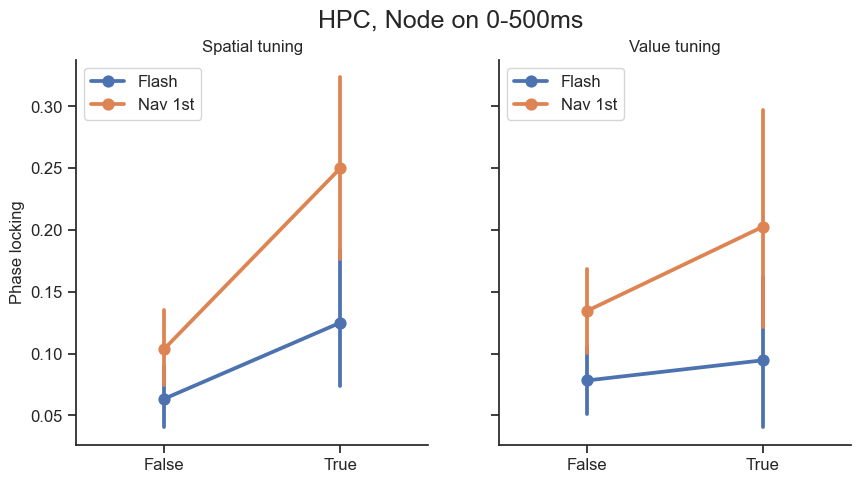

In [172]:
region = 'HPC'
df = first_step.query('(region==@region)')

plt.close('all')
fig, axes = plt.subplots(1,2,figsize=(10,5),sharey=True)

table = pd.crosstab(df['spatial_reg'], df['flash_PLV'])
odds_ratio, p_one_sided = fisher_exact(table, alternative='greater')
print("Flash One-sided p-value =", p_one_sided)

table = pd.crosstab(df['spatial_reg'], df['nav_PLV'])
odds_ratio, p_one_sided = fisher_exact(table, alternative='greater')
print("Nav One-sided p-value =", p_one_sided)

sns.pointplot(data=df,x='spatial_reg',y='flash_PLV',label='Flash', ax=axes[0])
sns.pointplot(data=df,x='spatial_reg',y='nav_PLV',label='Nav 1st', ax=axes[0])
axes[0].set_title('Spatial tuning')
axes[0].set_xlabel('')
axes[0].set_ylabel('Phase locking')


table = pd.crosstab(df['value'], df['flash_PLV'])
odds_ratio, p_one_sided = fisher_exact(table, alternative='greater')
print("Flash One-sided p-value =", p_one_sided)

table = pd.crosstab(df['value'], df['nav_PLV'])
odds_ratio, p_one_sided = fisher_exact(table, alternative='greater')
print("Nav One-sided p-value =", p_one_sided)

sns.pointplot(data=df,x='value',y='flash_PLV',label='Flash', ax=axes[1])
sns.pointplot(data=df,x='value',y='nav_PLV',label='Nav 1st', ax=axes[1])
axes[1].set_title('Value tuning')
axes[1].set_xlabel('')
plt.suptitle('HPC, Node on 0-500ms')
plt.savefig('D:/Theta/Node on 0 500ms, Phase locking, HPC')

In [178]:
first_step[(first_step.Session=='031723')&(first_step.region=='HPC')].query('unitNumber==188')

Animal Session  unitNumber       unitNames  channelNumbers  unitOnChannel  \
65   Bart  031723       188.0  S01_SPK183_001           183.0            1.0   

    probe  firingRate     date region  ...  \
65    6.0    2.333178  31723.0    HPC  ...   

                                   generic_value_pval  value  spatial_reg  \
65  [[0.2405426584176712, 0.3260739639765996, 0.59...  False         True   

    max_node                                  sig_diff_node_all  \
65       5.0  [7, 10, 13, 13, 13, 2, 11, 11, 13, 12, 13, 13,...   

    sig_diff_node  generic_target  generic_value  flash_PLV  nav_PLV  
65             13            True          False       True     True  

[1 rows x 53 columns]

Flash One-sided p-value = 0.0027125063782869477
Nav One-sided p-value = 0.002679766610848176
Flash One-sided p-value = 0.045052917110365825
Nav One-sided p-value = 0.2933922686343155


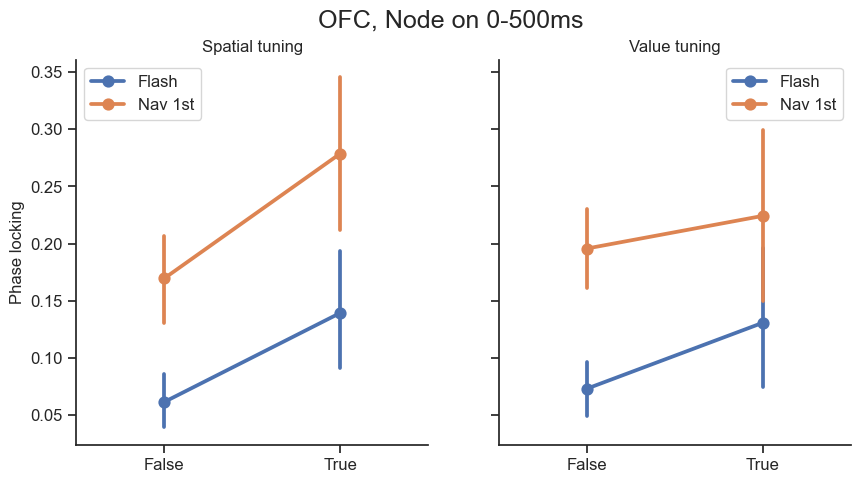

In [173]:
region = 'OFC'
df = first_step.query('(region==@region)')

plt.close('all')
fig, axes = plt.subplots(1,2,figsize=(10,5),sharey=True)

table = pd.crosstab(df['spatial_reg'], df['flash_PLV'])
odds_ratio, p_one_sided = fisher_exact(table, alternative='greater')
print("Flash One-sided p-value =", p_one_sided)

table = pd.crosstab(df['spatial_reg'], df['nav_PLV'])
odds_ratio, p_one_sided = fisher_exact(table, alternative='greater')
print("Nav One-sided p-value =", p_one_sided)

sns.pointplot(data=df,x='spatial_reg',y='flash_PLV',label='Flash', ax=axes[0])
sns.pointplot(data=df,x='spatial_reg',y='nav_PLV',label='Nav 1st', ax=axes[0])
axes[0].set_title('Spatial tuning')
axes[0].set_xlabel('')
axes[0].set_ylabel('Phase locking')


table = pd.crosstab(df['value'], df['flash_PLV'])
odds_ratio, p_one_sided = fisher_exact(table, alternative='greater')
print("Flash One-sided p-value =", p_one_sided)

table = pd.crosstab(df['value'], df['nav_PLV'])
odds_ratio, p_one_sided = fisher_exact(table, alternative='greater')
print("Nav One-sided p-value =", p_one_sided)

sns.pointplot(data=df,x='value',y='flash_PLV',label='Flash', ax=axes[1])
sns.pointplot(data=df,x='value',y='nav_PLV',label='Nav 1st', ax=axes[1])
axes[1].set_title('Value tuning')
axes[1].set_xlabel('')
plt.suptitle('OFC, Node on 0-500ms')
plt.savefig('D:/Theta/Node on 0 500ms, Phase locking, OFC')

In [87]:
region = 'OFC'
date = '031723'

print(first_step.query('spatial_reg & (region==@region) & (Session==@date)').nav_PLV.mean())
print(first_step.query('(~spatial_reg) & (region==@region) & (Session==@date)').nav_PLV.mean())

print(all_neurons.query('spatial_reg & (region==@region) & (Session==@date)').nav_PLV.mean())
print(all_neurons.query('(~spatial_reg) & (region==@region) & (Session==@date)').nav_PLV.mean())

0.25
0.16129032258064516
0.23404255319148937
0.13953488372093023


In [89]:
region = 'OFC'

print(first_step.query('spatial_reg & (region==@region) ').nav_PLV.mean())
print(first_step.query('(~spatial_reg) & (region==@region) ').nav_PLV.mean())

print(all_neurons.query('spatial_reg & (region==@region) ').nav_PLV.mean())
print(all_neurons.query('(~spatial_reg) & (region==@region) ').nav_PLV.mean())

0.18787878787878787
0.09828009828009827
0.16279069767441862
0.10084033613445378


In [90]:
region = 'HPC'

print(first_step.query('spatial_reg & (region==@region) ').nav_PLV.mean())
print(first_step.query('(~spatial_reg) & (region==@region) ').nav_PLV.mean())

print(all_neurons.query('spatial_reg & (region==@region) ').nav_PLV.mean())
print(all_neurons.query('(~spatial_reg) & (region==@region) ').nav_PLV.mean())

0.14705882352941177
0.06051873198847262
0.09395973154362416
0.08083832335329341


In [81]:
region = 'HPC'
subfield = 'CA3'
print(all_neurons_old.query('spatial_reg & (region==@region) & (subfield==@subfield)').nav_PLV.mean())
print(all_neurons_old.query('(~spatial_reg) & (region==@region) & (subfield==@subfield)').nav_PLV.mean())

0.2647058823529412
0.08695652173913043


In [70]:
region = 'HPC'
subfield = 'CA3'
print(all_neurons_old.query('nav_PLV & (region==@region) & (subfield==@subfield)').spatial_reg.mean())
print(all_neurons_old.query('(~nav_PLV) & (region==@region) & (subfield==@subfield)').spatial_reg.mean())

0.6923076923076923
0.373134328358209


In [88]:
region = 'OFC'
# subfield = 'CA3'
print(first_step.query('nav_PLV & (region==@region) ').spatial_reg.mean())
print(all_neurons.query('nav_PLV & (region==@region) ').spatial_reg.mean())
print(first_step.query('(~nav_PLV) & (region==@region) ').spatial_reg.mean())
print(all_neurons.query('(~nav_PLV) & (region==@region) ').spatial_reg.mean())

0.43661971830985913
0.49295774647887325
0.26746506986027946
0.3592814371257485


In [49]:
region = 'HPC'
print(first_step.query('nav_PLV & (region==@region)').value.mean())
print(all_neurons.query('nav_PLV & (region==@region)').value.mean())
print(first_step.query('~nav_PLV & (region==@region)').value.mean())
print(all_neurons.query('~nav_PLV & (region==@region)').value.mean())

0.14634146341463414
0.2926829268292683
0.15384615384615385
0.3190045248868778


In [46]:
region = 'OFC'
print(first_step.query('nav_PLV & (region==@region)').spatial_reg.mean())
print(all_neurons.query('nav_PLV & (region==@region)').spatial_reg.mean())

0.43661971830985913
0.49295774647887325


In [103]:
def format_pval(p):
    if p >= 0.01:
        return f"{p:.2f}"
    else:
        return f"{p:.1e}"

In [7]:
# get the channel that has a certain unit

query = 'trialerror<2'

for date in ['031723','032023','032823','033123','040423','040723']:

    nwbfile = load_data.load_nwbfile('Bart',date) 
    node_df = nwbfile.intervals['node_on'].to_dataframe().query(query)

    timestamps, lfpData = load_data.load_LFP(date)
    lfpFile = h5py.File('D:/Teleworld/bart_I/raw/spikes/Bart_TeleWorld_v13_%s-spikes.mat' % date, 'r')
    spikeTable = lfpFile['spikeTable'][:len(timestamps),:]
    unitNames = nwbfile.units.to_dataframe()
    channelNumbers = unitNames.channelNumbers.values
    
    all_PLV = []
    
    for unit in range(len(unitNames)):
    
        channel = channelNumbers[unit]-1  
        
        unit_PLV = []
        
        for trial in tqdm(node_df.trial.unique()):
            
            # get timestamps for the trial of interest
            idx = (node_df.trial==trial) & (node_df.step==0)
            node_on = node_df.t_on.values[idx]
            time_idx = (timestamps>node_on) & (timestamps<(node_on+500))
            
            # get phase
            ds = ThetaDataset("D:/Theta/Session_%s_theta.h5" % date)
            phase = ds.get_phase(time_idx)[:,channel]
            ds.close()
            
            # get raw LFP and spikes
            lfp_chunk = lfpData[time_idx, channel]
            spike_chunk = spikeTable[time_idx, unit]
            
            # phase value within the alignment window
            unit_PLV.append(phase[spike_chunk.astype(bool)])
    
        all_PLV.append(unit_PLV)
    
    
    flash_plv_pval = np.zeros(len(unitNames))
    nav_plv_pal = np.zeros(len(unitNames))
    
    for unit in range(len(unitNames)):
        
        idx = trial_df.trialerror.values==1
        flash_plv = np.concatenate([plv for plv, keep in zip(all_PLV[unit], idx) if keep])
        zscore, pval = pg.circ_rayleigh(flash_plv)
        flash_plv_pval[unit]=pval
    
        idx = trial_df.trialerror.values==0
        flash_plv = np.concatenate([plv for plv, keep in zip(all_PLV[unit], idx) if keep])
        zscore, pval = pg.circ_rayleigh(flash_plv)
        nav_plv_pal[unit]=pval
    
    data_to_save = {'PLV':all_PLV,
                    'flash_pval':flash_plv_pval,
                    'nav_pval':nav_plv_pal}
    with open(f'D:/Theta/Session_{date}_node_on_0_500_PLV.pkl','wb') as file:
        pickle.dump(data_to_save,file)

 49%|████▊     | 486/1000 [00:15<00:16, 31.71it/s]


KeyboardInterrupt: 

In [156]:
hpc_tuning = pd.read_pickle("D:/SingleNeuron/Tuning first step HPC.pkl")
ofc_tuning = pd.read_pickle("D:/SingleNeuron/Tuning first step OFC.pkl")
session_tuning = pd.concat([ofc_tuning.query('Session==@date'),hpc_tuning.query('Session==@date')])
unit_params = {"drift": 2, "min_fr": 1}  
unit_idx = np.where((unitNames.group == "good") & (unitNames.drift <= unit_params["drift"]) & (unitNames.fr >= unit_params["min_fr"]))[0]
good_units = unitNames.iloc[unit_idx]
session_tuning['flash_PLV'] = flash_plv_pval[unit_idx]<0.001
session_tuning['nav_PLV'] = nav_plv_pal[unit_idx]<0.001

In [159]:
region = 'OFC'
session_tuning.query('nav_PLV & (region==@region)').spatial_reg.mean()

np.float64(0.37142857142857144)

In [160]:
region = 'HPC'
session_tuning.query('nav_PLV & (region==@region)').value.mean()

np.float64(0.23076923076923078)

In [161]:
region = 'OFC'
session_tuning.query('~nav_PLV & (region==@region)').spatial_reg.mean()

np.float64(0.2727272727272727)

In [162]:
region = 'HPC'
session_tuning.query('~nav_PLV & (region==@region)').value.mean()

np.float64(0.23880597014925373)

In [163]:
region = 'HPC'
session_tuning.query('nav_PLV & (region==@region)').spatial_reg.mean()

np.float64(0.6923076923076923)

In [164]:
region = 'HPC'
session_tuning.query('~nav_PLV & (region==@region)').spatial_reg.mean()

np.float64(0.373134328358209)

In [165]:
region = 'HPC'
session_tuning.query('spatial_reg & (region==@region)').nav_PLV.mean()

np.float64(0.2647058823529412)

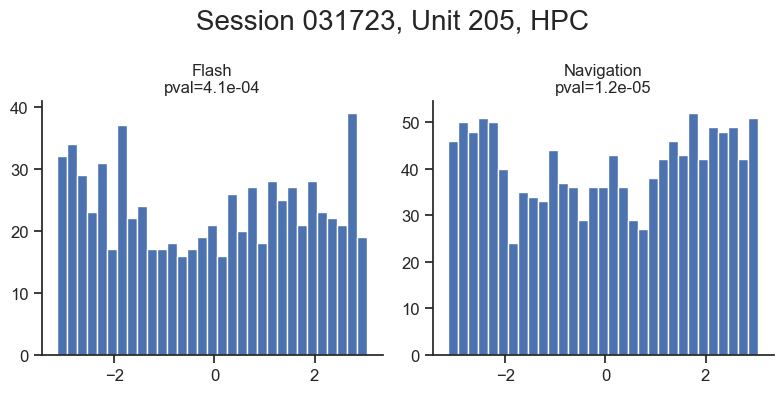

In [107]:
flash_plv_pval = np.zeros(len(unitNames))
nav_plv_pal = np.zeros(len(unitNames))

for unit in range(len(unitNames)):

    plt.close('all')
    fig, axes = plt.subplots(1,2,figsize=(8,4))
    
    idx = trial_df.trialerror.values==1
    flash_plv = np.concatenate([plv for plv, keep in zip(all_PLV[unit], idx) if keep])
    zscore, pval = pg.circ_rayleigh(flash_plv)
    flash_plv_pval[unit]=pval
    axes[0].hist(flash_plv,bins=np.arange(-np.pi,np.pi,0.2))
    axes[0].set_title(f"Flash\npval={format_pval(pval)}")
    
    idx = trial_df.trialerror.values==0
    flash_plv = np.concatenate([plv for plv, keep in zip(all_PLV[unit], idx) if keep])
    zscore, pval = pg.circ_rayleigh(flash_plv)
    nav_plv_pal[unit]=pval
    axes[1].hist(flash_plv,bins=np.arange(-np.pi,np.pi,0.2))
    axes[1].set_title(f"Navigation\npval={format_pval(pval)}")
    
    plt.suptitle(f'Session {date}, Unit {unit+1}, {unitNames.region.values[unit]}',fontsize=20)
    plt.tight_layout()
    plt.savefig('D:/Theta/phase locking unit %i'%unit)

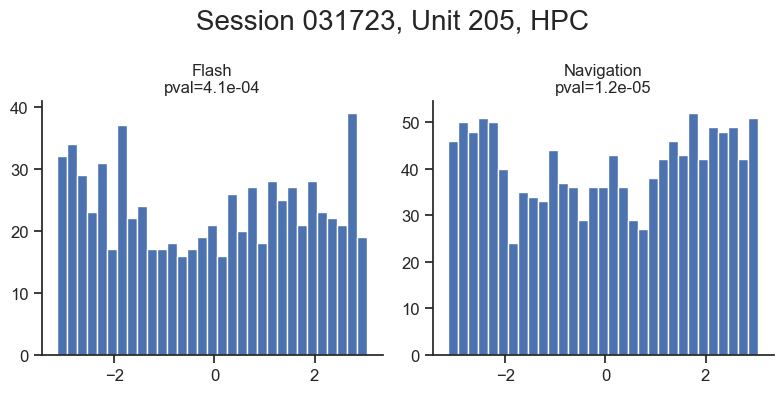

In [107]:

for unit in range(len(unitNames)):

    plt.close('all')
    fig, axes = plt.subplots(1,2,figsize=(8,4))
    
    idx = trial_df.trialerror.values==1
    flash_plv = np.concatenate([plv for plv, keep in zip(all_PLV[unit], idx) if keep])
    zscore, pval = pg.circ_rayleigh(flash_plv)
    flash_plv_pval[unit]=pval
    axes[0].hist(flash_plv,bins=np.arange(-np.pi,np.pi,0.2))
    axes[0].set_title(f"Flash\npval={format_pval(pval)}")
    
    idx = trial_df.trialerror.values==0
    flash_plv = np.concatenate([plv for plv, keep in zip(all_PLV[unit], idx) if keep])
    zscore, pval = pg.circ_rayleigh(flash_plv)
    nav_plv_pal[unit]=pval
    axes[1].hist(flash_plv,bins=np.arange(-np.pi,np.pi,0.2))
    axes[1].set_title(f"Navigation\npval={format_pval(pval)}")
    
    plt.suptitle(f'Session {date}, Unit {unit+1}, {unitNames.region.values[unit]}',fontsize=20)
    plt.tight_layout()
    plt.savefig('D:/Theta/phase locking unit %i'%unit)

In [166]:
region = 'HPC'
session_tuning.query('~spatial_reg & (region==@region)').nav_PLV.mean()

np.float64(0.08695652173913043)

In [ ]:
# get phase value for the first 2 theta cycles after node onset
# this is the index within the alignment window
peaktimes,_ = find_peaks(phase,height=3)
peak1_idx = peaktimes[0]
peak3_idx = peaktimes[2]

# get timestamps from the index
peak1_ts = node_on + peak1_idx
peak3_ts = node_on + peak3_idx

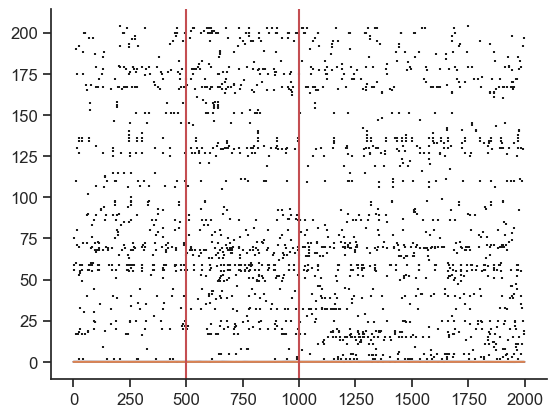

In [158]:



lfp_chunk = lfpData[time_idx, OFC_channel]
spike_chunk = spikeTable[time_idx, unit]
plt.plot(chunk)
plt.plot(node_aligned['band'][0,OFC_channel,:])
X, Y = np.where(spike_chunk)
plt.scatter(X,Y,marker = "|", c="k", s=1)
plt.axvline(500,color='r')
plt.axvline(1000,color='r')

In [159]:
unitNames = nwbfile.units.to_dataframe()
channelNumbers = unitNames.channelNumbers.values
channel = channelNumbers[unit]

In [182]:
PLV = []
# for unit in range(len(spikeTable.shape[1])):
unit = 3
channel = channelNumbers[unit]
unit_PLV = node_aligned['phase'][trial,channel,spike_chunk[:,unit].astype(bool)]

In [175]:
node_aligned['phase'][trial,channel,:].shape #spike_chunk[unit,:]].shape

(2000,)

In [178]:
spike_chunk[unit,:].shape

(205,)

In [184]:
unit_PLV

array([ 2.6509373,  1.5673281,  2.2617273,  1.4173714, -2.9460483,
       -2.1106994,  1.9670701,  2.419659 , -2.200394 , -1.4745724],
      dtype=float32)

In [145]:
x,y=np.where(spike_chunk.reshape(-1,1))

In [147]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

In [120]:
trough_2nd

np.int64(262)

In [119]:
peak_3rd

np.int64(374)

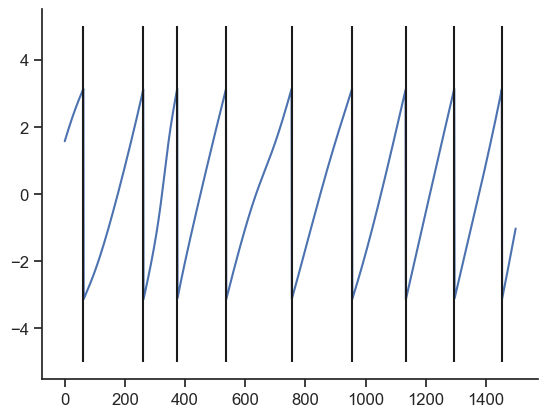

In [112]:
plt.plot(trial_phase)
plt.vlines(peaktime,-5,5,color='k')

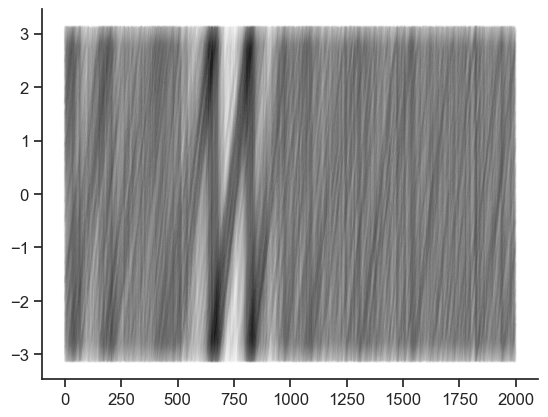

In [86]:
plt.plot(phase[:, 20, :].T, color='k',alpha=0.01)

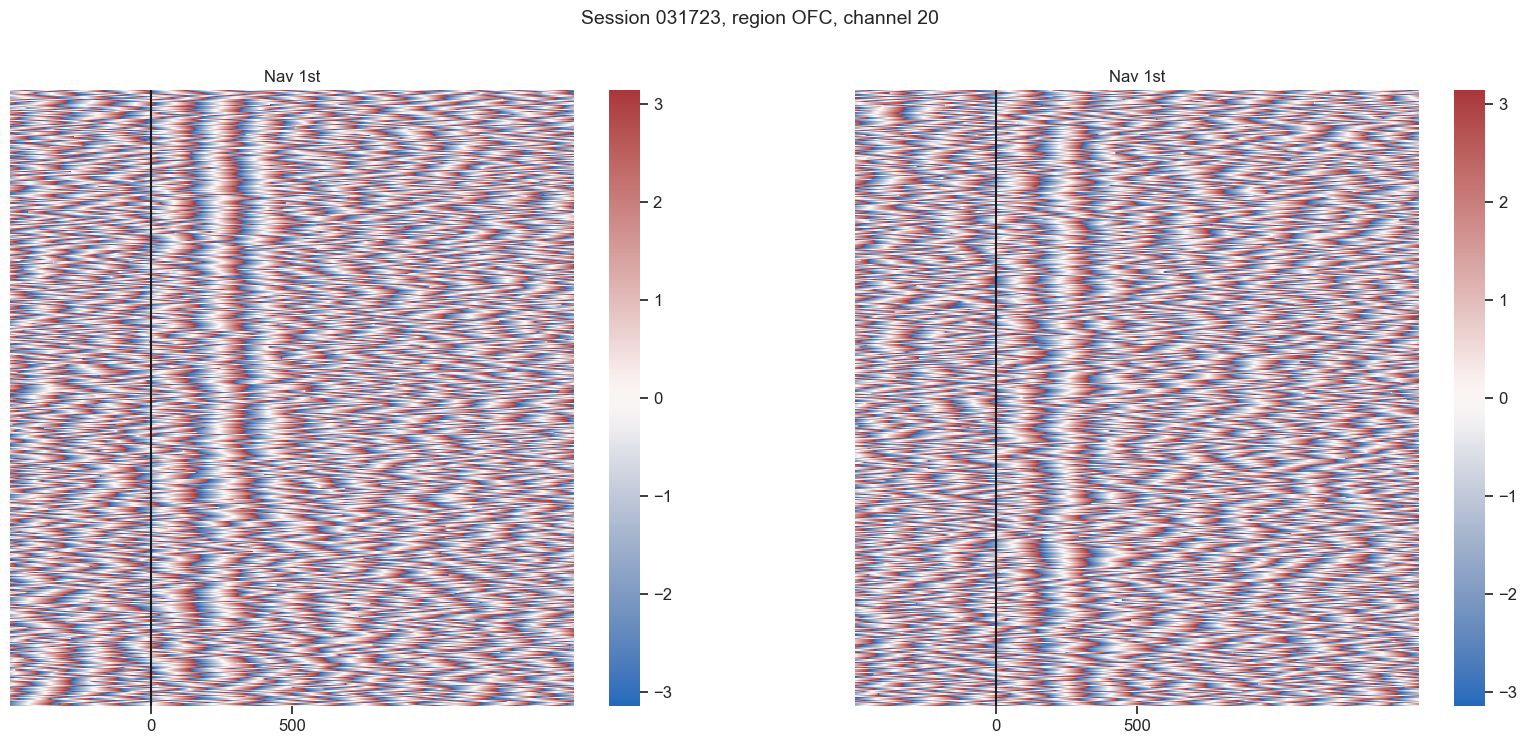

In [73]:
phase = node_aligned['phase'][(node_df.trialerror==0) & (node_df.step==0),:,:]

# node on
OFC_channel = 20
plt.close('all')
fig, axes = plt.subplots(1,2,figsize=(20,8))

idx = np.argsort(RT)
sns.heatmap(phase[idx,OFC_channel,:],cmap='vlag',ax=axes[0])
# axes[0].plot(500+np.sort(RT),np.arange(len(RT)),color='k')
axes[0].axvline(500,color='k')
axes[0].set_xticks([500,1000])
axes[0].set_xticklabels([0,500],rotation=0)
axes[0].set_yticks([])
axes[0].set_title('Nav 1st')

idx = np.argsort(node_df.query('(trialerror==0) & (step==0)').nsteps.values)
sns.heatmap(phase[idx,OFC_channel,:],cmap='vlag',ax=axes[1])
# axes[0].plot(500+np.sort(RT),np.arange(len(RT)),color='k')
axes[1].axvline(500,color='k')
axes[1].set_xticks([500,1000])
axes[1].set_xticklabels([0,500],rotation=0)
axes[1].set_yticks([])
axes[1].set_title('Nav 1st')

plt.suptitle(f"Session {date}, region OFC, channel {OFC_channel}",fontsize=14)
plt.savefig(f"D:/Theta/Phase sort by RT 2, Session {date}, region OFC, channel {OFC_channel}")

Text(0.5, 0.98, 'Session 031723, region OFC, channel 20')

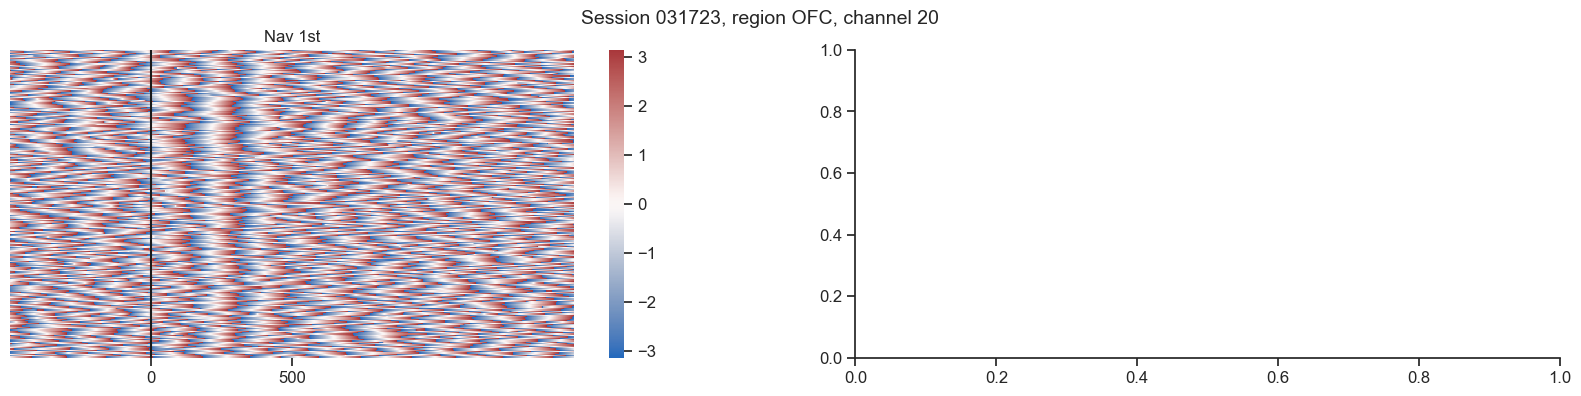

In [81]:
phase = node_aligned['phase'][(node_df.trialerror==1) & (node_df.step==0),:,:]

# node on
OFC_channel = 20
plt.close('all')
fig, axes = plt.subplots(1,2,figsize=(20,4))

idx = np.argsort(node_df.query('trialerror==1').blocktrialnumber.values)
sns.heatmap(phase[:,OFC_channel,:],cmap='vlag',ax=axes[0])
# axes[0].plot(500+np.sort(RT),np.arange(len(RT)),color='k')
axes[0].axvline(500,color='k')
axes[0].set_xticks([500,1000])
axes[0].set_xticklabels([0,500],rotation=0)
axes[0].set_yticks([])
axes[0].set_title('Nav 1st')

plt.suptitle(f"Session {date}, region OFC, channel {OFC_channel}",fontsize=14)
# plt.savefig(f"D:/Theta/Phase sort by RT 2, Session {date}, region OFC, channel {OFC_channel}")

Text(0.5, 0.98, 'Session 031723, region OFC, channel 20')

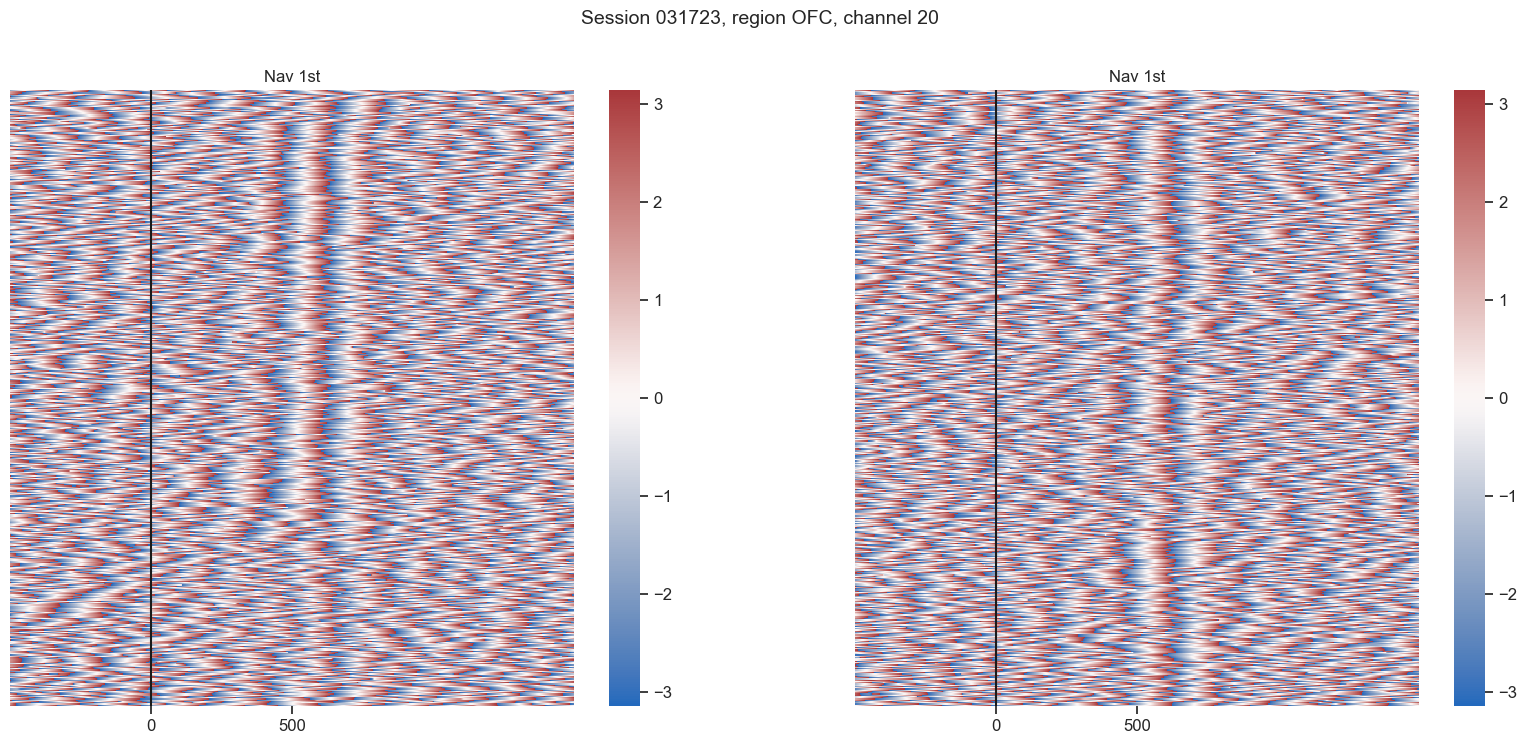

In [76]:
action_phase = action_aligned['phase'][(action_df.trialerror==0) & (action_df.step==0),:,:]

# node on
OFC_channel = 20
plt.close('all')
fig, axes = plt.subplots(1,2,figsize=(20,8))

idx = np.argsort(RT)
sns.heatmap(action_phase[idx,OFC_channel,:],cmap='vlag',ax=axes[0])
# axes[0].plot(500+np.sort(RT),np.arange(len(RT)),color='k')
axes[0].axvline(1000,color='k')
axes[0].set_xticks([500,1000])
axes[0].set_xticklabels([0,500],rotation=0)
axes[0].set_yticks([])
axes[0].set_title('Nav 1st')

idx = np.argsort(action_df.query('(trialerror==0) & (step==0)').nsteps.values)
sns.heatmap(action_phase[idx,OFC_channel,:],cmap='vlag',ax=axes[1])
# axes[0].plot(500+np.sort(RT),np.arange(len(RT)),color='k')
axes[1].axvline(1000,color='k')
axes[1].set_xticks([500,1000])
axes[1].set_xticklabels([0,500],rotation=0)
axes[1].set_yticks([])
axes[1].set_title('Nav 1st')

plt.suptitle(f"Session {date}, region OFC, channel {OFC_channel}",fontsize=14)
# plt.savefig(f"D:/Theta/Phase sort by RT 2, Session {date}, region OFC, channel {OFC_channel}")

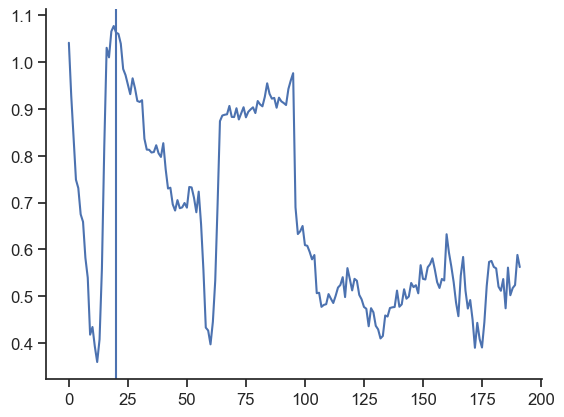

In [35]:
plt.plot(np.max(phase.mean(axis=0),axis=1))
plt.axvline(20)

In [9]:
# load data
date = '031723'
phase_align = np.load('D:/Theta/Session %s, theta phase alignment.npz' % date)['arr_0']
nwbfile = load_data.load_nwbfile('Bart',date) 

query = 'trialerror<2'
trial_df = nwbfile.intervals['trials'].to_dataframe().query(query)
trial_df['t_on']=trial_df['start_time']

node_df = nwbfile.intervals['node_on'].to_dataframe().query(query)
action_df = nwbfile.intervals['action_on'].to_dataframe().query(query)
# reward_df = nwbfile.intervals['reward_on'].to_dataframe().query(query)
# fix_df = nwbfile.intervals['fixations'].to_dataframe().query(query)

# get aligned_power for all trials
# trial_aligned = epoch_aligned_band(date,trial_df,[-3000,1000])
# node_aligned = epoch_aligned_band(date,node_df,[-500,1500])
# action_aligned = epoch_aligned_band(date,action_df,[-1000,1000])
# reward_aligned = epoch_aligned_band(date,reward_df,[-1000,3000])
# fix_aligned = epoch_aligned_band(date,fix_df,[-500,500])

In [74]:
action_aligned = epoch_aligned_band(date,action_df,[-1000,1000])

In [140]:
# load data
# for date in ['031723','032023','032823','033123','040423','040723']:

date = '031723'
phase_align = np.load('D:/Theta/Session %s, theta phase alignment.npz' % date)['arr_0']
nwbfile = load_data.load_nwbfile('Bart',date) 

query = '(trialerror==0) & (step>0)'
node_df = nwbfile.intervals['node_on'].to_dataframe().query(query)
node_aligned1 = epoch_aligned_band(date,node_df,[-1000,1000])

query = '(trialerror==0) & (step==0)'
node_df = nwbfile.intervals['node_on'].to_dataframe().query(query)
node_aligned2 = epoch_aligned_band(date,node_df,[-1000,1000])

query = '(trialerror==1)'
node_df = nwbfile.intervals['node_on'].to_dataframe().query(query)
node_aligned3 = epoch_aligned_band(date,node_df,[-1000,1000])

# reward_df = nwbfile.intervals['reward_on'].to_dataframe().query(query)
# reward_aligned = epoch_aligned_band(date,reward_df,[-1000,3000])


In [ ]:
unitNames = nwbfile.units.to_dataframe()
probes = unitNames.drop_duplicates('probe')
probes['subfield']

In [37]:
def plot_mean_sem(timestamps,sig,axis,ax,color,label):
    mean = sig.mean(axis=axis)
    sem = sig.std(axis=axis)/np.sqrt(sig.shape[axis])
    ax.plot(timestamps,mean,color=color,label=label)
    ax.fill_between(timestamps,mean-sem,mean+sem,alpha=0.2,color=color)

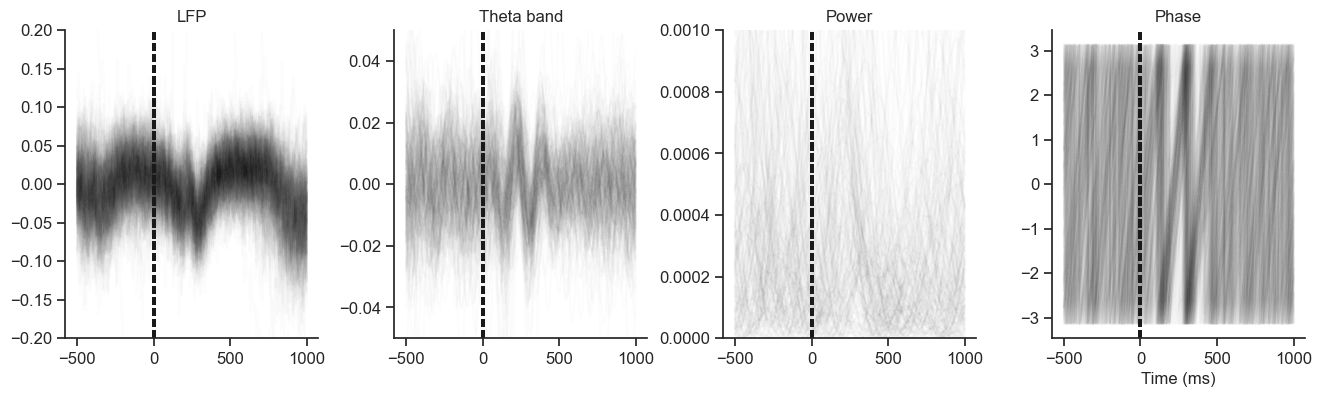

In [125]:
channel = OFC_channel
aligned_ts = np.arange(-500,1000)

plt.close('all')
fig, axes = plt.subplots(
    1, 4, figsize=(16, 4),
    sharex=True,
    sharey=False,
    gridspec_kw=dict(hspace=0, wspace=0.3)   # <-- remove vertical space
)

for ii, trial in enumerate(cand_trials):

    start_time = int(node_df.query('trial==@trial').t_on.values[0])
    timestamps = np.arange(start_time-500, start_time+1000)

    ds = ThetaDataset("D:/Theta/Session_%s_theta.h5" % date)
    band_sig, power, phase = ds.get_trace(timestamps)
    ds.close()
    
    # --- 1. Raw LFP ---
    axes[0].plot(aligned_ts, lfpData[timestamps, :][:, channel], color='k',alpha=0.01)
    # axes[0, 0].plot(aligned_ts, band_sig[channel, :], color='k',alpha=0.01)
    axes[0].axvline(0, color='k', ls='--')
    axes[0].set_ylim(-0.2,0.2)

    axes[1].plot(aligned_ts, band_sig[channel, :], color='k',alpha=0.01)
    axes[1].axvline(0, color='k', ls='--')
    axes[1].set_ylim(-0.05,0.05)
    
    # --- 2. Power ---
    axes[2].plot(aligned_ts, power[channel, :], color='k',alpha=0.01)
    axes[2].axvline(0, color='k', ls='--')
    axes[2].set_ylim(0,0.001)

    # --- 3. Phase ---
    axes[3].plot(aligned_ts, phase[channel, :], color='k',alpha=0.01)
    axes[3].axvline(0, color='k', ls='--')
    axes[3].set_xlabel("Time (ms)")  # this will stay only for bottom row later

axes[0].set_title("LFP")
axes[1].set_title("Theta band")
axes[2].set_title("Power")
axes[3].set_title("Phase")

plt.savefig('D:/Theta/overlay traces')